In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [8]:
data = pd.read_csv("data_tog.csv", index_col=0)
min_value = data.iloc[:, 5:].min().min()
data = data.fillna(min_value - 1)
data.iloc[:, 5:] = data.iloc[:, 5:] + (min_value - 1)*(-1)

In [9]:
name_mac_relation = pd.read_csv("mac_name_relation.csv", index_col=0)
good_aps = name_mac_relation[name_mac_relation['ap_name'].isin( ["Guest-CentraleSupelec", "eduroam", 'stop&go', 'CD91', 'fabrique2024'])]["ap_mac"].to_list()
columns_to_maintain  = good_aps + data.columns[:5].to_list()
data = data[data.columns.intersection(columns_to_maintain)]

In [10]:
data['room_part'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [11]:
AP_columns = list(data.columns[5:])

In [12]:
non_AP_columns = list(data.columns[:5])


In [13]:
data.room.unique()

array(['LC410', 'LC412', 'LC414', 'LC416', 'LC415', 'LC437', 'LC442',
       'LC443', 'LC448', 'LC426', 'LC424', 'LC455', 'LC417', 'LC413'],
      dtype=object)

In [14]:
data

,timestamp,room,device_id,door_status,room_part,70:d3:79:2e:8c:80:,70:d3:79:2e:8c:83:,70:d3:79:2e:8c:84:,70:d3:79:2e:8c:86:,70:d3:79:2e:8c:88:,...,94:d4:69:fd:b2:2c:,94:d4:69:fd:b2:2f:,a4:88:73:4e:03:80:,a4:88:73:4e:03:84:,a4:88:73:4e:03:86:,a4:88:73:4e:03:87:,a4:88:73:4e:40:c0:,a4:88:73:4e:40:c4:,a4:88:73:4e:40:c6:,a4:88:73:4e:40:c7:
0,1.709565e+09,LC410,V,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.709565e+09,LC410,V,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.709565e+09,LC410,V,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.709565e+09,LC410,V,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.709565e+09,LC410,V,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25218,1.710180e+09,LC413,R,1,5,0.0,19.0,20.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25219,1.710180e+09,LC413,R,1,5,0.0,19.0,20.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25220,1.710180e+09,LC413,R,1,5,0.0,19.0,20.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25221,1.710180e+09,LC413,R,1,5,0.0,19.0,20.0,0.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plots

In [15]:
rooms = list(data["room"].unique()) 


# Filter

In [16]:
data_to_remove_outliers = data.groupby(["room", "room_part", "device_id"])

aux = []
for name, data_grouped in data_to_remove_outliers:
    data_grouped = data_grouped.reset_index()
    mean = data_grouped[AP_columns].mean()
    
    for ap in AP_columns:
        if mean[ap] > 5:
            for i in range(len(data_grouped)):
                if data_grouped.at[i, ap] == 0:
                    # Find the nearest non-zero value
                    nearest_non_zero = None
                    left_index = i - 1
                    right_index = i + 1
                    
                    while nearest_non_zero is None:
                        if left_index >= 0 and data_grouped.at[left_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[left_index, ap]
                        elif right_index < len(data_grouped) and data_grouped.at[right_index, ap] != 0:
                            nearest_non_zero = data_grouped.at[right_index, ap]
                        else:
                            left_index -= 1
                            right_index += 1
                    
                    # Replace the zero value with the nearest non-zero value
                    data_grouped.at[i, ap] = nearest_non_zero

    aux.append(data_grouped)


data_filtered_without_outliers = pd.concat(aux, ignore_index=True)


    

In [17]:
data_to_filter = data_filtered_without_outliers.groupby(["room", "room_part", "device_id"])

aux = []
alpha = 0.5
for name, data_grouped in data_to_filter:
    # data_filtered.loc[len(data_filtered.index)] = data_grouped.iloc[0]
    filtered_values = data_grouped.iloc[0][AP_columns]
    for _, values in data_grouped.iterrows():
        filtered_values = alpha*values[AP_columns] + (1-alpha)*filtered_values
        # data_filtered.loc[len(data_filtered.index)] = list(values[non_AP_columns]) + list(filtered_values)
        aux.append(list(values[non_AP_columns]) + list(filtered_values))


data_filtered = pd.DataFrame(aux, columns=data.columns)

    

In [18]:
data_filtered.room.unique

<bound method Series.unique of 0        LC410
1        LC410
2        LC410
3        LC410
4        LC410
         ...  
25218    LC455
25219    LC455
25220    LC455
25221    LC455
25222    LC455
Name: room, Length: 25223, dtype: object>

In [19]:
rooms_analyse = ['LC410', 'LC412', 'LC413', 'LC414', 'LC415', 'LC416', 'LC417']
data_filtered = data_filtered[data_filtered['room'].isin(rooms_analyse)]

In [20]:
from scipy.special import gamma
from scipy.special import hyp2f1

import scipy

class TLoc:         

    def __init__(self, train_data: pd.DataFrame):
        # self.non_null_minimum_percentage = 0.1
        self.train_data = train_data
        # self.aps = self.get_aps_with_non_zero_minimum_percentage(self.train_data)
        self.aps = list(self.train_data.columns[1:])
        if len(self.aps) == 1:
            self.max_power = int(self.train_data[self.aps].max())
        else:
            self.max_power = int(self.train_data[self.aps].max().max())


        self.spaces = list(self.train_data["room"].unique())

        self.power_probability_masks = {}
        self.power_prior_probability_distribution = {}
        self.eps = 1e-5


    def get_aps_with_non_zero_minimum_percentage(self, data):
        percentage_of_non_zeros = (data.iloc[:, 5:] != 0).sum() / data.shape[0]
        return data.columns[5:][percentage_of_non_zeros >= self.non_null_minimum_percentage]
    


    def get_mu_and_phi_estimation(self, data, router):
        mu = []
        phi = []
        data_of_router = data[["room", router]]
        for space in self.spaces:
            data_of_router_in_space = data_of_router[data_of_router["room"] == space]

            data_of_router_in_space_without_zero_values = data_of_router_in_space[data_of_router_in_space[router] != 0]
            if len(data_of_router_in_space_without_zero_values) == 0:
                mu.append(0.0)
            else:
                mu.append(data_of_router_in_space_without_zero_values[router].mean())
            phi.append(1 - data_of_router_in_space_without_zero_values.shape[0] / data_of_router_in_space.shape[0])

        return mu, phi



    def train(self):
        for router in self.aps:


            self.power_probability_masks[router] = {}
            self.power_prior_probability_distribution[router] = {}

            mu, phi = self.get_mu_and_phi_estimation(self.train_data, router)


            total_num_samples_in_router = self.train_data[router].shape[0]
            for power in range(0, self.max_power):
                self.power_probability_masks[router][
                    power] = self.approximate_position_density_function_given_router(power, np.array(mu),
                                                                                    np.array(phi))
                num_samples_with_value_power_in_router = (self.train_data[router] == power).sum()

                self.power_prior_probability_distribution[router][
                    power] = num_samples_with_value_power_in_router / total_num_samples_in_router

                    

    def cumulative_distribution_function_of_t_student(self, x, v):

        return 0.5 + x * gamma((v + 1) / 2) * hyp2f1(1 / 2, (v + 1) / 2, 3 / 2, -(x ** 2) / v) / (
                np.sqrt(v * np.pi) * gamma(v / 2))
    
    def cumulative_distribution_function_of_power(self, power, mu, phi, sigma, v):

        cdf = phi * np.heaviside(power, 1) + (1 - phi) * self.cumulative_distribution_function_of_t_student(
            (power - mu) / sigma, v)
        
        return cdf
    

    def approximate_position_density_function_given_router(self, power, mu, phi, sigma=5, num_samples_per_ap=30, t_score_alpha=0.05):

        v = np.ceil(num_samples_per_ap * (1 - phi) - 1)
        v = np.where(v <= 0, 1, v)

        t_score = scipy.stats.t.ppf(0.5 + t_score_alpha, v)

        density_function = self.cumulative_distribution_function_of_power(power + t_score * sigma, mu, phi, sigma, v) - self.cumulative_distribution_function_of_power(
                    power - t_score * sigma, mu, phi, sigma, v)  # power, mu, phi, sigma, v

        return density_function
    

    def pred(self, X_test):

        y_pred = []
        min_prob = self.eps * np.ones(len(self.spaces))

        for _, test_sample in X_test.iterrows():

            distribution_xy_given_bf = np.ones(len(self.spaces))

            for router in self.aps:

                    power = int(test_sample[router])

                    try:
                        prob_p_given_xybfr = self.power_probability_masks[router][power]
                    except KeyError:
                        # print(f"Error predicting router {router}, power {power}")
                        continue
                    


                    prob_p_given_xybfr = np.maximum(prob_p_given_xybfr, min_prob)
                    #prob_p_given_xybfr = prob_p_given_xybfr / prob_p_given_xybfr.sum()
                    #prob_xy_given_pbfr = prob_p_given_xybfr / (
                    #                tloc.eps + tloc.power_prior_probability_distribution[router][power])


                    distribution_xy_given_bf = distribution_xy_given_bf * prob_p_given_xybfr




            room_pred = self.spaces[distribution_xy_given_bf.argmax()]
            y_pred.append(room_pred)

        y_pred = np.array(y_pred)
        ground_truth = np.array(list(X_test["room"]))
        ac = np.sum(y_pred == ground_truth)/len(ground_truth)
        return ac, y_pred, ground_truth

In [101]:
train_data = data[data["device_id"] != "V"]
test_data = data[data["device_id"] == "V" ]

In [115]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [116]:
columns_to_train = [train_data.columns[1]] + list(train_data.columns[5:])

In [126]:
train_data = train_data.reset_index().drop(columns='index')
test_data = test_data.reset_index().drop(columns= 'index')

test_data_colour_indices = test_data[(test_data['room_part'] == 5) & (test_data['door_status'] == 1)].index


In [118]:
tloc = TLoc(train_data[columns_to_train])
tloc.train()

In [119]:
accuracy, prediction, ground_truth = tloc.pred(test_data)

In [120]:
accuracy


0.9502477700693757

In [121]:
prediction

array(['LC417', 'LC410', 'LC415', ..., 'LC426', 'LC443', 'LC442'],
      dtype='<U5')

In [122]:
ground_truth

array(['LC417', 'LC410', 'LC415', ..., 'LC426', 'LC443', 'LC442'],
      dtype='<U5')

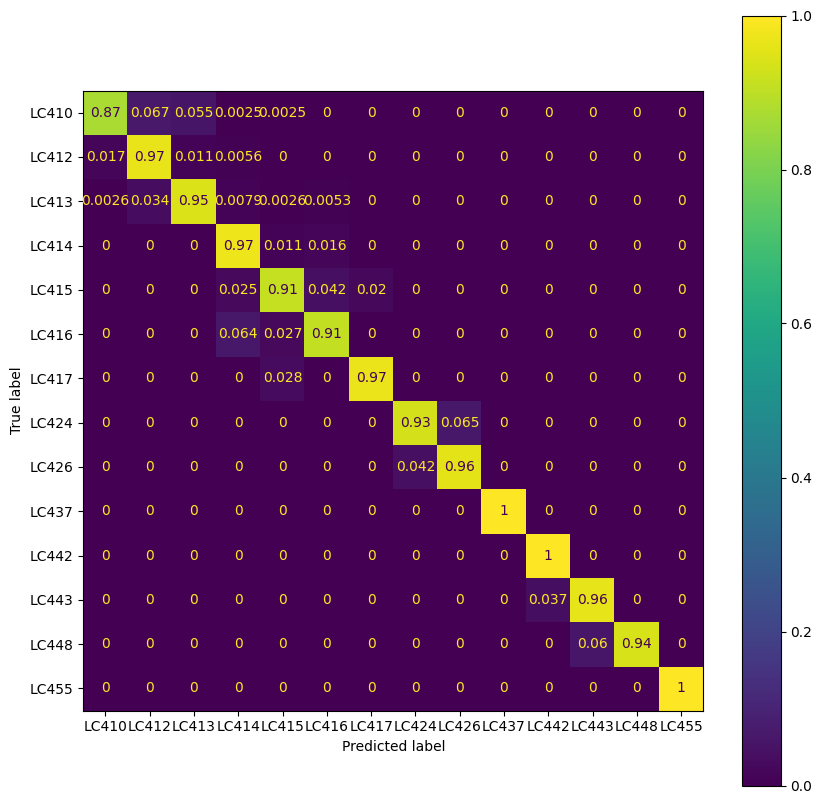

In [123]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(prediction, ground_truth, normalize='true'), display_labels=list(np.unique(ground_truth)))
cmd.plot(ax=ax)
plt.show()

Accuracy for room LC410: 0.9804469273743017
Accuracy for room LC412: 0.896640826873385
Accuracy for room LC413: 0.9322916666666666
Accuracy for room LC414: 0.899749373433584
Accuracy for room LC415: 0.9368686868686869
Accuracy for room LC416: 0.9320652173913043
Accuracy for room LC417: 0.9753086419753086


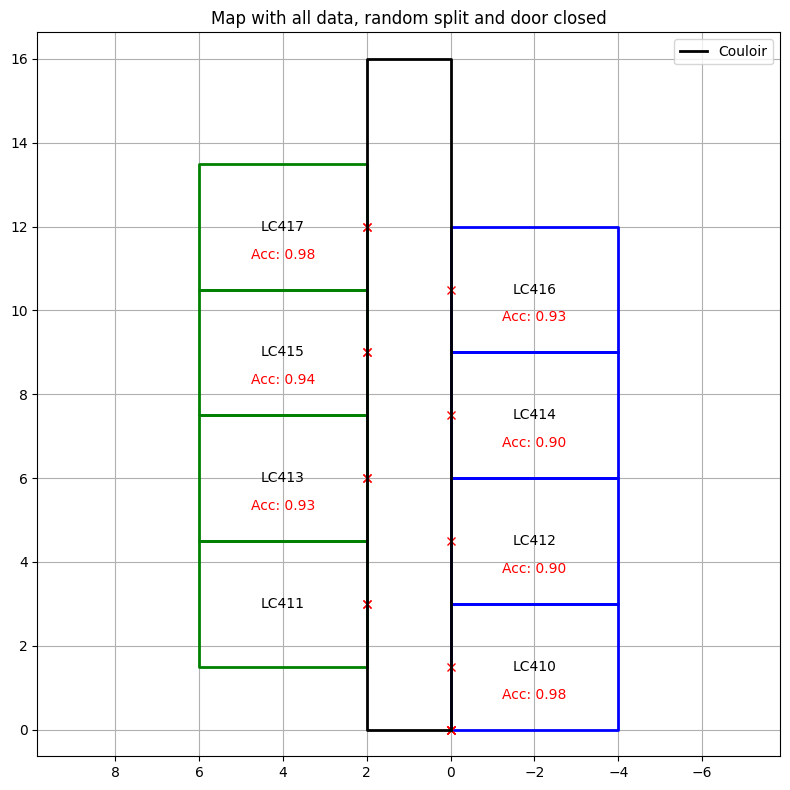

In [128]:

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Dictionary to store accuracy for each room
room_accuracies = {}

rooms_analyse = ['LC410', 'LC412', 'LC413', 'LC414', 'LC415', 'LC416', 'LC417']

for room in rooms_analyse:

    room_predictions = [prediction[i] for i in range(len(prediction)) if ground_truth[i] == room]
    room_ground_truth = [room for label in room_predictions]
    accuracy = accuracy_score(room_ground_truth, room_predictions)
    room_accuracies[room] = accuracy



######### COULOIR #########

'''Drawing showing the accuracies, corridor and rooms

'''
corridor_width = 2
corridor_length = 16
room_width = 3
room_length = 4
half_room_width = room_width / 2

# Coordinates of the corridor
corridor_x = [0, corridor_width, corridor_width, 0, 0]
corridor_y = [0, 0, corridor_length, corridor_length, 0]

# Coordinates of the rooms
room_x = []
room_y = []
room_names = []
entries_x = []
entries_y = []

plt.figure(figsize=(8, 8))

# Adding rooms alternating between sides
for i, room_name in enumerate(['LC410', 'LC411', 'LC412', 'LC413', 'LC414', 'LC415', 'LC416', 'LC417']):
    room_names.append(room_name)  # Adding room name to the list

    # alternating the sides, supposed to each door to be in the middle of the other from the other side
    
    if i % 2 == 0:  # left side
        room_x.append([0, 0, -room_length, -room_length, 0])
        room_y.append([(i // 2) * room_width, ((i // 2) + 1) * room_width, ((i // 2) + 1) * room_width,
                       (i // 2) * room_width, (i // 2) * room_width])
        plt.plot(room_x[i], room_y[i], 'b-', linewidth=2)
        # Coordinates of the room center
        center_room_x = -room_length / 2
        center_room_y = ((i // 2) + 0.5) * room_width
        plt.text(center_room_x, center_room_y, room_name, ha='center', va='center', fontsize=10)
        # Coordinates of the room entrance
        entries_x.append([0, 0])
        entries_y.append([0, (i // 2) * room_width + half_room_width])

    else:  # right side
        room_x.append([corridor_width, corridor_width, corridor_width + room_length,
                       corridor_width + room_length, corridor_width])
        room_y.append([((i - 1) // 2) * room_width + half_room_width,
                       (((i - 1) // 2) + 1) * room_width + half_room_width,
                       (((i - 1) // 2) + 1) * room_width + half_room_width,
                       ((i - 1) // 2) * room_width + half_room_width,
                       ((i - 1) // 2) * room_width + half_room_width])
        plt.plot(room_x[i], room_y[i], 'g-', linewidth=2)
        # Coordinates of the room center
        center_room_x = corridor_width + room_length / 2
        center_room_y = (((i - 1) // 2) + 0.5) * room_width + half_room_width
        plt.text(center_room_x, center_room_y, room_name, ha='center', va='center', fontsize=10)
        # Coordinates of the room entrance
        entries_x.append([corridor_width, corridor_width])
        entries_y.append([((i - 1) // 2) * room_width + room_width, ((i - 1) // 2) * room_width + room_width])

# Plotting room entrances
for i in range(len(entries_x)):
    plt.plot(entries_x[i], entries_y[i], 'rx')

# Plotting accuracy below the room name in the middle of each room
for room, accuracy in room_accuracies.items():
    idx = room_names.index(room)
    if idx % 2 == 0:  # left side
        middle_room_x = room_x[idx][0] - room_length / 2
    else:  # right side
        middle_room_x = room_x[idx][0] + room_length / 2
    middle_room_y = room_y[idx][0] + half_room_width  # y-coordinate of the text in the middle of the room
    plt.text(middle_room_x, middle_room_y - 0.5, f'Acc: {accuracy:.2f}', ha='center', va='top', fontsize=10,
             color='red')

plt.plot(corridor_x, corridor_y, 'k-', linewidth=2, label='Couloir')


plt.title('Map with all data, random split and door closed')
plt.axis('equal')
plt.gca().invert_xaxis()  # Inverting x-axis
plt.legend()  # Adding legend
plt.tight_layout()
plt.show()


In [77]:
prediction = prediction[test_data_colour_indices]
ground_truth = ground_truth[test_data_colour_indices]


1004